<a href="https://colab.research.google.com/github/denis201520182022/colorization-project/blob/new-model/colorize_and_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from skimage import color



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader

class CIFAR10_Lab(Dataset):
  def __init__(self, train=True):
    self.data = CIFAR10(root='./data', train=train, download=True)
    self.images = self.data.data

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_rgb = self.images[idx]/255.0
    img_lab = color.rgb2lab(img_rgb)

    L = img_lab[:,:, 0] / 100.0
    ab = img_lab[:,:, 1:] / 128.0

    L_tenzor = torch.tensor(L, dtype=torch.float32).unsqueeze(0)
    ab_tenzor = torch.tensor(ab, dtype=torch.float32).permute(2,0,1)

    return L_tenzor, ab_tenzor

In [4]:
train_dataset = CIFAR10_Lab(train=True)
test_dataset = CIFAR10_Lab(train=False)

train_loader =DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

100%|██████████| 170M/170M [00:05<00:00, 32.4MB/s]


Тип L: <class 'torch.Tensor'>  | Форма: torch.Size([1, 32, 32])
Тип ab: <class 'torch.Tensor'>  | Форма: torch.Size([2, 32, 32])
L_np: (32, 32)
ab_np (до транспонирования): (2, 32, 32)
ab_np (после): (32, 32, 2)


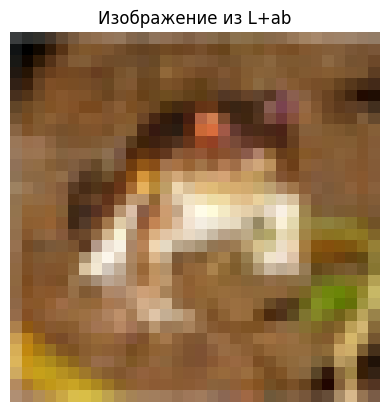

In [14]:
L, ab = train_dataset[0]

print("Тип L:", type(L), " | Форма:", L.shape)
print("Тип ab:", type(ab), " | Форма:", ab.shape)

L_np = L.squeeze().numpy() * 100
ab_np = ab.numpy() * 128

print("L_np:", L_np.shape)
print("ab_np (до транспонирования):", ab_np.shape)

ab_np = ab_np.transpose(1, 2, 0)
print("ab_np (после):", ab_np.shape)

lab_img = np.zeros((32, 32, 3), dtype=np.float32)
lab_img[:, :, 0] = L_np
lab_img[:, :, 1:] = ab_np

rgb_img = lab2rgb(lab_img)

plt.imshow(rgb_img)
plt.axis('off')
plt.title("Изображение из L+ab")
plt.show()


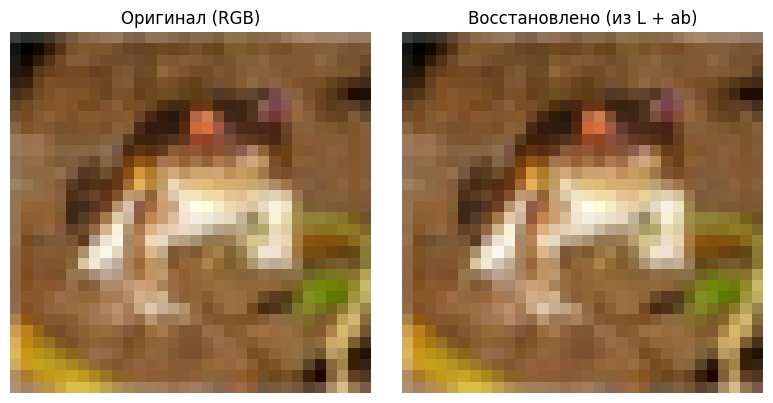

In [18]:
import matplotlib.pyplot as plt
original_img = train_dataset.data.data[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(original_img)
axs[0].set_title("Оригинал (RGB)")
axs[0].axis('off')

axs[1].imshow(rgb_img)
axs[1].set_title("Восстановлено (из L + ab)")
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ColorizationCNN(nn.Module):
    def __init__(self):
        super(ColorizationCNN, self).__init__()

        # Encoder: уменьшает размер, но увеличивает глубину (кол-во каналов)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # (1, 32, 32) -> (64, 32, 32)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (128, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (128, 16, 16)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # (256, 8, 8)
        )

        # Decoder: восстанавливает размер до исходного (32x32), но с 2 каналами
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # (128, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # (64, 32, 32)
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=3, padding=1),             # (2, 32, 32)
            nn.Tanh()  # чтобы выход был от -1 до 1, как и ab каналы
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [41]:
model = ColorizationCNN().to(device)

model.load_state_dict(torch.load('colorization_weights.pth'))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer.load_state_dict(torch.load('optimizer_weights.pth'))
criterion = nn.MSELoss()

In [42]:
num_epochs = 20
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0

  for batch in train_loader:
    L, ab = batch
    L, ab = L.to(device), ab.to(device)

    output = model(L)
    loss = criterion(output, ab)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  print(f"Эпоха {epoch+1}/{num_epochs}, Потеря: {avg_loss:.4f}")


Эпоха 1/20, Потеря: 0.0093
Эпоха 2/20, Потеря: 0.0092
Эпоха 3/20, Потеря: 0.0092
Эпоха 4/20, Потеря: 0.0092
Эпоха 5/20, Потеря: 0.0092
Эпоха 6/20, Потеря: 0.0092
Эпоха 7/20, Потеря: 0.0091
Эпоха 8/20, Потеря: 0.0091
Эпоха 9/20, Потеря: 0.0091
Эпоха 10/20, Потеря: 0.0091
Эпоха 11/20, Потеря: 0.0091
Эпоха 12/20, Потеря: 0.0091
Эпоха 13/20, Потеря: 0.0091
Эпоха 14/20, Потеря: 0.0090
Эпоха 15/20, Потеря: 0.0090
Эпоха 16/20, Потеря: 0.0090
Эпоха 17/20, Потеря: 0.0090
Эпоха 18/20, Потеря: 0.0090
Эпоха 19/20, Потеря: 0.0090
Эпоха 20/20, Потеря: 0.0090


In [43]:
# Тестируем модель на тестовом наборе данных
total_loss = 0
total_psnr = 0
total_samples = 0

with torch.no_grad():  # Отключаем градиенты для ускорения
    for L, ab in test_loader:
        L, ab = L.to(device), ab.to(device)

        # Прогоняем через модель
        ab_pred = model(L)

        # Считаем ошибку
        loss = criterion(ab_pred, ab)
        total_loss += loss.item() * L.size(0)  # Умножаем на размер батча
        total_samples += L.size(0)

        # Рассчитываем PSNR
        psnr_value = psnr(ab_pred, ab)
        total_psnr += psnr_value.item()

# Средние значения метрик
avg_test_loss = total_loss / total_samples
avg_psnr = total_psnr / total_samples

# Печатаем результаты
print(f"Средняя ошибка на тестовом наборе (MSE): {avg_test_loss:.4f}")
print(f"Средний PSNR: {avg_psnr:.4f} dB")


Средняя ошибка на тестовом наборе (MSE): 0.0092
Средний PSNR: 0.6402 dB


10 эпох:
Средняя ошибка на тестовом наборе (MSE): 0.0093
Средний PSNR: 0.6389 dB
30 эпох:
Средняя ошибка на тестовом наборе (MSE): 0.0092
Средний PSNR: 0.6402 dB


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

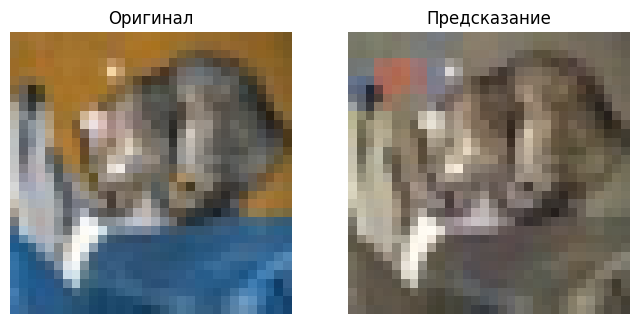

In [44]:
model.eval()

L, ab = test_dataset[0]

L_input = L.unsqueeze(0).to(device)

with torch.no_grad():
  ab_pred = model(L_input)

ab_pred = ab_pred.squeeze(0).cpu()
L_np = L.squeeze().numpy()*100
ab_np = ab_pred.numpy().transpose(1,2,0)*128

lab_pred = np.concatenate([L_np[..., np.newaxis], ab_np], axis=2)  # (32, 32, 3)
rgb_pred = color.lab2rgb(lab_pred)

original_rgb = test_dataset.data.data[0]  # uint8 RGB
original_rgb = original_rgb  # нормализуем [0, 1]

# Визуализация
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(original_rgb)
axs[0].set_title("Оригинал")
axs[0].axis("off")

axs[1].imshow(rgb_pred)
axs[1].set_title("Предсказание")
axs[1].axis("off")

In [45]:
from google.colab import files

torch.save(model.state_dict(), "colorization_weights.pth")
torch.save(model, "colorization_model.pth")
torch.save(optimizer.state_dict(), 'optimizer_weights.pth')

files.download("colorization_weights.pth")
files.download("colorization_model.pth")
files.download("optimizer_weights.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

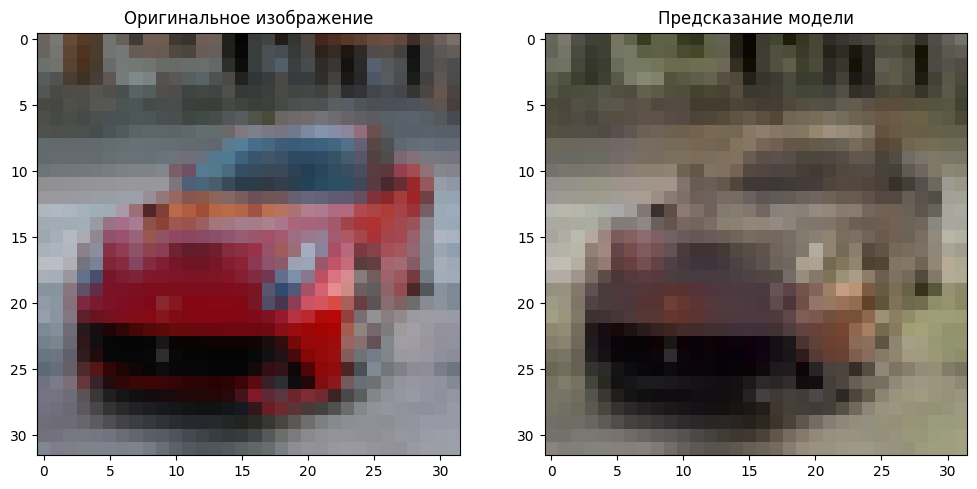

In [48]:
import torch
import requests
from PIL import Image
import numpy as np
from torchvision import transforms
from skimage import color
import matplotlib.pyplot as plt

# Загрузка изображения с интернета
image_url = "https://www.1zoom.me/big2/819/321881-svetik.jpg"  # Замените на актуальную ссылку
response = requests.get(image_url, stream=True)
img = Image.open(response.raw)

# Предобработка изображения
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Размер, соответствующий входу модели
    transforms.ToTensor(),  # Перевод в тензор
])

img_tensor = transform(img).unsqueeze(0)  # Добавляем дополнительную ось для батча (1, C, H, W)

# Преобразуем в цветовое пространство Lab
img_rgb = img_tensor.squeeze().numpy().transpose(1, 2, 0)  # Преобразуем обратно в numpy array
img_lab = color.rgb2lab(img_rgb)  # Преобразуем в Lab

L = img_lab[:, :, 0] / 100.0  # Канал L (светлота)
ab = img_lab[:, :, 1:] / 128.0  # Каналы a и b

# Перемещаем данные на нужное устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Преобразуем данные в тензоры
L_tensor = torch.tensor(L, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)
ab_tensor = torch.tensor(ab, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2).to(device)  # (1, 2, H, W)

# Перемещаем модель на тот же девайс
model.to(device)
model.eval()  # Переводим модель в режим оценки

# Прогоняем изображение через модель
with torch.no_grad():  # Отключаем вычисление градиентов
    output = model(L_tensor)  # Получаем предсказание модели

# Визуализация
output = output.squeeze().permute(1, 2, 0).cpu().numpy()  # Переводим результат в numpy для визуализации

# Собираем Lab и конвертируем в RGB
ab_pred = output * 128.0  # Каналы a, b в диапазоне [-128, 128]
L_pred = L * 100.0  # Канал L в диапазоне [0, 100]

lab_pred = np.concatenate([L_pred[..., np.newaxis], ab_pred], axis=-1)
rgb_pred = color.lab2rgb(lab_pred)

# Визуализируем
plt.figure(figsize=(12, 6))

# Оригинал
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Оригинальное изображение")

# Результат модели
plt.subplot(1, 2, 2)
plt.imshow(rgb_pred)
plt.title("Предсказание модели")

plt.show()
